In [1]:
#Importing packages and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from gensim import models

#For preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle

#For RNN-lstm
from keras.models import Model
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Embedding, Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D

#For RNN- bi lstm
from tensorflow.keras import regularizers
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional

#For model evaluation 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
import logging
logging.basicConfig(level=logging.INFO)

Mounting drive for datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/My Drive/BT4222_final_project/

/content/drive/My Drive/BT4222_final_project


In [4]:
cleaned = pd.read_csv('./data/cleaned_subreddits.csv')

In [5]:
data = cleaned.copy()

In [6]:
data.head()

,Unnamed: 0,clean_title,is_onion
0,9238,police took black toddler family suv union use...,0
1,15109,risk wetherspoons staff test positive,0
2,13935,louisiana officer claimed someone shot actuall...,0
3,5017,north carolina voter heavily gerrymandered dis...,1
4,7965,fall grace gatorade sales plummeted french foo...,1


In [7]:
type(data['clean_title'])

pandas.core.series.Series

In [8]:
strings = []
for sen in data['clean_title']:
  sen = str(sen)
  strings.append(sen)

data['clean_title'] = strings

In [9]:
#splitting the clean_title into an array of tokens
biglst = []
for sen in data['clean_title']:
  lst = sen.split(" ")
  biglst.append(lst)

data['tokens'] = biglst

In [10]:
data

,Unnamed: 0,clean_title,is_onion,tokens
0,9238,police took black toddler family suv union use...,0,"[police, took, black, toddler, family, suv, un..."
1,15109,risk wetherspoons staff test positive,0,"[risk, wetherspoons, staff, test, positive]"
2,13935,louisiana officer claimed someone shot actuall...,0,"[louisiana, officer, claimed, someone, shot, a..."
3,5017,north carolina voter heavily gerrymandered dis...,1,"[north, carolina, voter, heavily, gerrymandere..."
4,7965,fall grace gatorade sales plummeted french foo...,1,"[fall, grace, gatorade, sales, plummeted, fren..."
...,...,...,...,...
16461,10440,amazon delivery boy delhi tells customer order...,0,"[amazon, delivery, boy, delhi, tells, customer..."
16462,4919,liberal hypocrisy media gorgon rachel maddow c...,1,"[liberal, hypocrisy, media, gorgon, rachel, ma..."
16463,11634,man attempting resurrect grandmother accused c...,0,"[man, attempting, resurrect, grandmother, accu..."
16464,8539,syracuse police chief unable complete ny certi...,0,"[syracuse, police, chief, unable, complete, ny..."


In [11]:
#create one hot encoding for the target variable  
onion = []
notonion = []
for l in data.is_onion:
    if l == 0:
        onion.append(0)
        notonion.append(1)
    elif l == 1:
        onion.append(1)
        notonion.append(0)

data['onion']= onion
data['notonion']= notonion

In [12]:
#split train test
data_train, data_test = train_test_split(data, test_size=0.20, random_state=4222)

In [13]:
#training data
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

114454 words total, with a vocabulary size of 18788
Max sentence length is 46


In [14]:
#testing data
all_test_words = [word for tokens in data_test['tokens'] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test['tokens']]
TEST_VOCAB = sorted(list(set(all_test_words)))
print('%s words total, with a vocabulary size of %s' % (len(all_test_words), len(TEST_VOCAB)))
print('Max sentence length is %s' % max(test_sentence_lengths))

28493 words total, with a vocabulary size of 9293
Max sentence length is 33


Getting the Google News word2vec model 

In [16]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-11-19 01:52:55--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.145.149
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.145.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  73.1MB/s    in 19s     

2020-11-19 01:53:14 (82.4 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [17]:
word2vec_path = '/root/input/GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

INFO:gensim.models.utils_any2vec:loading projection weights from /root/input/GoogleNews-vectors-negative300.bin.gz
INFO:gensim.models.utils_any2vec:loaded (3000000, 300) matrix from /root/input/GoogleNews-vectors-negative300.bin.gz


In [18]:
MAX_SEQUENCE_LENGTH = 46
EMBEDDING_DIM = 300



Tokenise and pad sequence

In [19]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train['clean_title'].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train['clean_title'].tolist())
train_word_index = tokenizer.word_index
print("Found %s unique tokens." % len(train_word_index))
train_cnn_data = pad_sequences(training_sequences, 
                               maxlen=MAX_SEQUENCE_LENGTH)

Found 18788 unique tokens.


In [20]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [21]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(18789, 300)


In [22]:
test_sequences = tokenizer.texts_to_sequences(data_test['clean_title'].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)


Define RNN-lstm

In [23]:
label_names = ['onion', 'notonion']

In [24]:
y_train = data_train[label_names].values

In [25]:
x_train = train_cnn_data
y_tr = y_train

In [148]:
def recurrent_nn(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    #lstm = LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedded_sequences)
    
    lstm = (LSTM(256, dropout=0.5)(embedded_sequences))
  
    x = Dense(300, kernel_regularizer = regularizers.l2(0.0001), activation='relu')(lstm)
    x = Dropout(0.5)(x)
    preds = Dense(labels_index, kernel_regularizer = regularizers.l2(0.0001), activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [149]:
model = recurrent_nn(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 46, 300)           5636700   
_________________________________________________________________
lstm_37 (LSTM)               (None, 256)               570368    
_________________________________________________________________
dense_36 (Dense)             (None, 300)               77100     
_________________________________________________________________
dropout_36 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 602       
Total params: 6,284,770
Trainable params: 648,070
Non-trainable params: 5,636,700
_____________________________________

In [43]:
num_epochs = 5
batch_size = 15

In [150]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/5
791/791 [==============================] - 5s 6ms/step - loss: 0.6044 - acc: 0.6847 - val_loss: 0.5315 - val_acc: 0.7534
Epoch 2/5
791/791 [==============================] - 5s 6ms/step - loss: 0.5496 - acc: 0.7302 - val_loss: 0.5000 - val_acc: 0.7443
Epoch 3/5
791/791 [==============================] - 5s 6ms/step - loss: 0.5156 - acc: 0.7451 - val_loss: 0.4891 - val_acc: 0.7656
Epoch 4/5
791/791 [==============================] - 4s 6ms/step - loss: 0.4825 - acc: 0.7740 - val_loss: 0.4456 - val_acc: 0.7944
Epoch 5/5
791/791 [==============================] - 5s 6ms/step - loss: 0.4527 - acc: 0.7894 - val_loss: 0.4244 - val_acc: 0.8073


In [34]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

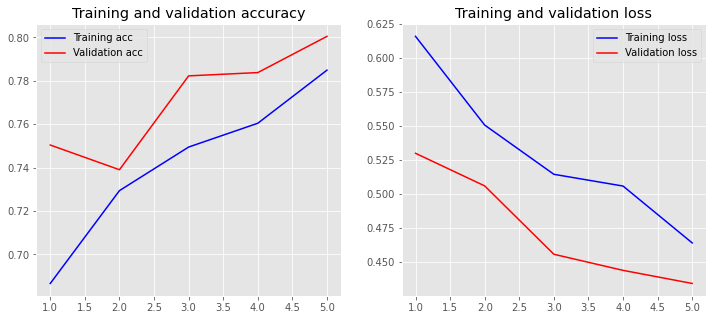

In [52]:
plot_history(history)

Testing the model with unseen data

In [151]:
predictions = model.predict(test_cnn_data, batch_size=128, verbose=1)

26/26 [==============================] - 0s 7ms/step


In [37]:
labels = [1, 0]

In [152]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [153]:
acc = accuracy_score(prediction_labels, data_test['is_onion'])
print(acc)

0.781117182756527


In [154]:
print(classification_report(data_test.is_onion, prediction_labels))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1612
           1       0.81      0.75      0.78      1682

    accuracy                           0.78      3294
   macro avg       0.78      0.78      0.78      3294
weighted avg       0.78      0.78      0.78      3294



### Bidirectional LSTM 


In [57]:
data = cleaned.copy()

In [58]:
data.head()

,Unnamed: 0,clean_title,is_onion
0,9238,police took black toddler family suv union use...,0
1,15109,risk wetherspoons staff test positive,0
2,13935,louisiana officer claimed someone shot actuall...,0
3,5017,north carolina voter heavily gerrymandered dis...,1
4,7965,fall grace gatorade sales plummeted french foo...,1


In [59]:
strings = []
for sen in data['clean_title']:
  sen = str(sen)
  strings.append(sen)

data['clean_title'] = strings

Getting a different word embedding for improved results 

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2020-11-18 11:32:40--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-11-18 11:32:40--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-11-18 11:32:40--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
!unzip glove.twitter.27B*.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


Data pre preprocessing 


In [73]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=50):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    # pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    # Uncomment above line to save the tokenizer as .pkl file 
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]
    embeddings_dict = {}
    f = open("glove.twitter.27B.50d.txt", encoding="utf8")
    #f = open(models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True), encoding="utf8")
    #f = open(word2vec, encoding="utf8")
    #word2vec_path
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)

Building bi directional LSTM model


In [188]:
def build_bilstm(word_index, embeddings_dict, nclasses=2,  MAX_SEQUENCE_LENGTH=50, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 1, lstm_node = 256):
    # Initialize a sequebtial model
    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0)))
    model.add(Dropout(dropout))
    # fully connected layer 
    model.add(Dense(300, kernel_regularizer = regularizers.l2(0.0001),activation='relu'))
    model.add(Dropout(dropout))
    # output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses,kernel_regularizer = regularizers.l2(0.0001), activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [198]:
X = data.clean_title
y = data.is_onion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4222)
print("Preparing model input ...")
X_train_glove, X_test_glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)
print("Done!")
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Preparing model input ...
Found 20743 unique tokens.
(16466, 50)
Total 1193514 word vectors.
Done!
Building Model!
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 50, 50)            1037200   
_________________________________________________________________
bidirectional_44 (Bidirectio (None, 50, 512)           628736    
_________________________________________________________________
dropout_56 (Dropout)         (None, 50, 512)           0         
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 512)               1574912   
_________________________________________________________________
dropout_57 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 300)               153900    
____

In [190]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }
def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [199]:
history = model.fit(X_train_Glove, y_train,
                           validation_data=(X_test_Glove,y_test),
                           epochs=5,
                           batch_size=15,
                           shuffle=True,
                           verbose=1)

Epoch 1/5
879/879 [==============================] - 22s 25ms/step - loss: 0.5999 - accuracy: 0.7099 - val_loss: 0.5083 - val_accuracy: 0.7802
Epoch 2/5
879/879 [==============================] - 21s 24ms/step - loss: 0.4153 - accuracy: 0.8261 - val_loss: 0.4894 - val_accuracy: 0.7975
Epoch 3/5
879/879 [==============================] - 21s 24ms/step - loss: 0.2836 - accuracy: 0.8945 - val_loss: 0.4699 - val_accuracy: 0.8084
Epoch 4/5
879/879 [==============================] - 21s 24ms/step - loss: 0.1791 - accuracy: 0.9376 - val_loss: 0.5512 - val_accuracy: 0.8054
Epoch 5/5
879/879 [==============================] - 21s 24ms/step - loss: 0.1074 - accuracy: 0.9658 - val_loss: 0.7321 - val_accuracy: 0.8063


In [200]:
print("\n Evaluating Model ... \n")
predicted = model.predict_classes(X_test_Glove)
print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
print("\n")
result = compute_metrics(y_test, predicted)



 Evaluating Model ... 

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1612
           1       0.82      0.79      0.81      1682

    accuracy                           0.81      3294
   macro avg       0.81      0.81      0.81      3294
weighted avg       0.81      0.81      0.81      3294







In [201]:
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))

INFO:logger:  mcc = 0.6131982536546778
INFO:logger:  true positive = 1332
INFO:logger:  true negative = 1324
INFO:logger:  false positive = 288
INFO:logger:  false negative = 350
INFO:logger:  precision = 0.8222222222222222
INFO:logger:  recall = 0.7919143876337693
INFO:logger:  F1 = 0.8067837674136886
INFO:logger:  accuracy = 0.806314511232544


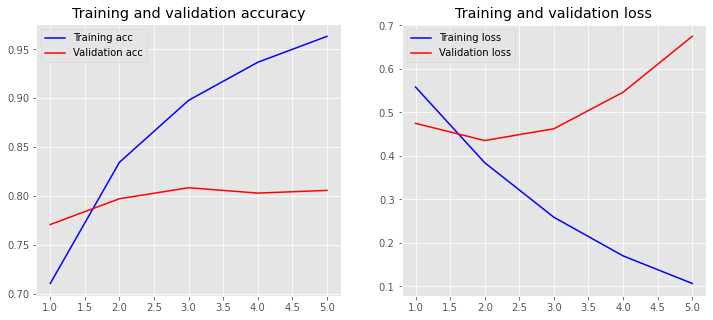

In [ ]:
plot_history(history)

In [ ]:
print(history.history)

{'loss': [0.5584679245948792, 0.38450106978416443, 0.25907379388809204, 0.17029227316379547, 0.1068456843495369], 'accuracy': [0.7105222940444946, 0.8344973921775818, 0.8978894352912903, 0.9368357062339783, 0.9633312821388245], 'val_loss': [0.47494733333587646, 0.4353845715522766, 0.4624845087528229, 0.5464385151863098, 0.674953818321228], 'val_accuracy': [0.7707954049110413, 0.7972070574760437, 0.8084396123886108, 0.8029751181602478, 0.8057073354721069]}
